<h1>Neural Translation Model in PyTorch</h1>
by Mac Brennan

<p style='text-align: center !important;'>
 <img src='https://github.com/macbrennan90/macbrennan90.github.io/blob/master/images/encoder-decoder.png?raw=true'
      alt='Translation Model Summary'>
</p>

This project will be broken up into several parts as follows:

__Part 1:__ Preparing the words

+ Inspecting the Dataset
+ Using Word Embeddings
+ Organizing the Data

__Part 2:__ Building the Model

+ Bi-Directional Encoder
+ Building Attention
+ Decoder with Attention

__Part 3:__ Training the Model

+ Training Function
+ Training Loop

__Part 4:__ Evaluation

In [246]:
# Before we get started we will load all the packages we will need

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os.path
import time
import math
import random
import matplotlib.pyplot as plt
import string

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [247]:
device

device(type='cuda')

## Part 1: Preparing the Words

### Inspecting the Dataset

The dataset that will be used is a text file of english sentences and the corresponding french sentences.

Each sentence is on a new line. The sentences will be split into a list.

#### Load the data
The data will be stored in two lists where each item is a sentence. The lists are:
+ english_sentences
+ french_sentences

In [248]:
with open('data/small_vocab_en', "r") as f:
    data1 = f.read()
with open('data/small_vocab_fr', "r") as f:
    data2 = f.read()
    
# The data is just in a text file with each sentence on its own line
english_sentences = data1.split('\n')
french_sentences = data2.split('\n')

In [249]:
print('Number of English sentences:', len(english_sentences), 
      '\nNumber of French sentences:', len(french_sentences),'\n')
print('Example/Target pair:\n')
print('  '+english_sentences[2])
print('  '+french_sentences[2])

Number of English sentences: 137861 
Number of French sentences: 137861 

Example/Target pair:

  california is usually quiet during march , and it is usually hot in june .
  california est généralement calme en mars , et il est généralement chaud en juin .


#### Vocabulary
Let's take a closer look at the dataset.


In [250]:
english_sentences[2].split()

['california',
 'is',
 'usually',
 'quiet',
 'during',
 'march',
 ',',
 'and',
 'it',
 'is',
 'usually',
 'hot',
 'in',
 'june',
 '.']

In [251]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)    

The longest english sentence in our dataset is: 17


In [253]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)

The longest french sentence in our dataset is: 23


In [254]:
seq_length = max(max_fr_length, max_en_length) + 1

In [255]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1


In [256]:
# Add end of sentence token to word count dict
en_word_count['</s>'] = len(english_sentences)
fr_word_count['</s>'] = len(english_sentences)

In [257]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 228
Number of unique French words: 356


In [258]:
def get_value(items_tuple):
    return items_tuple[1]

# Sort the word counts to see what words or most/least common
sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [259]:
sorted_en_words[:10]

[('is', 205858),
 (',', 140897),
 ('</s>', 137861),
 ('.', 129039),
 ('in', 75525),
 ('it', 75137),
 ('during', 74933),
 ('the', 67628),
 ('but', 63987),
 ('and', 59850)]

In [260]:
sorted_fr_words = sorted(fr_word_count.items(), key=get_value, reverse=True)

In [261]:
sorted_fr_words[:10]

[('est', 196809),
 ('</s>', 137861),
 ('.', 135619),
 (',', 123135),
 ('en', 105768),
 ('il', 84079),
 ('les', 65255),
 ('mais', 63987),
 ('et', 59851),
 ('la', 49861)]

So the dataset is pretty small, we may want to get a bigger data set, but we'll see how this one does.

#### Alternate Dataset
Skip this section for now. You can come back and try training on this second dataset later. It is more diverse so it takes longer to train.

In [298]:
with open('data/fra.txt', "r") as f:
    data1 = f.read()

In [372]:
pairs = data1.split('\n')
english_sentences = []
french_sentences = []
for i, pair in enumerate(pairs):
    pair_split = pair.split('\t')
    if len(pair_split)!= 2:
        continue
    english = pair_split[0].lower()
    french = pair_split[1].lower()
    
    # Remove punctuation and limit sentence length
    max_sent_length = 10
    punctuation_table = english.maketrans({i:None for i in string.punctuation})
    english = english.translate(punctuation_table)
    french = french.translate(punctuation_table)
    if len(english.split()) >= max_sent_length or len(french.split()) >= max_sent_length:
        continue
       
    english_sentences.append(english)
    french_sentences.append(french)

In [373]:
english_sentences[10000].split()


['i', 'have', 'to', 'hurry']

In [374]:
french_sentences[10000].split()

['je', 'dois', 'me', 'dépêcher']

In [375]:
print(english_sentences[-100].split())
french_sentences[-500].split()


['my', 'students', 'have', 'been', 'eagerly', 'awaiting', 'the', 'test', 'results']


['jai', 'fait', 'des', 'expériences', 'intéressantes', 'en', 'voyageant']

In [376]:
max_en_length = 0
for sentence in english_sentences:
    length = len(sentence.split())
    max_en_length = max(max_en_length, length)
print("The longest english sentence in our dataset is:", max_en_length)  

The longest english sentence in our dataset is: 9


In [377]:
max_fr_length = 0
for sentence in french_sentences:
    length = len(sentence.split())
    max_fr_length = max(max_fr_length, length)
print("The longest french sentence in our dataset is:", max_fr_length)  

The longest french sentence in our dataset is: 9


In [378]:
en_word_count = {}
fr_word_count = {}

for sentence in english_sentences:
    for word in sentence.split():
        if word in en_word_count:
            en_word_count[word] +=1
        else:
            en_word_count[word] = 1
            
for sentence in french_sentences:
    for word in sentence.split():
        if word in fr_word_count:
            fr_word_count[word] +=1
        else:
            fr_word_count[word] = 1


In [379]:
en_word_count['</s>'] = len(english_sentences)
fr_word_count['</s>'] = len(english_sentences)

In [380]:
print('Number of unique English words:', len(en_word_count))
print('Number of unique French words:', len(fr_word_count))

Number of unique English words: 11997
Number of unique French words: 24710


In [381]:
fr_word2idx = {k:v+3 for v, k in enumerate(fr_word_count.keys())}
en_word2idx = {k:v+3 for v, k in enumerate(en_word_count.keys())}

In [382]:
fr_word2idx['<pad>'] = 0
fr_word2idx['<s>'] = 1
fr_word2idx['<unk>'] = 2

en_word2idx['<pad>'] = 0
en_word2idx['<s>'] = 1
en_word2idx['<unk>'] = 2

In [383]:
len(fr_word2idx)

24713

In [384]:
def get_value(items_tuple):
    return items_tuple[1]

sorted_en_words= sorted(en_word_count.items(), key=get_value, reverse=True)

In [385]:
sorted_en_words[-10:]

[('attempting', 1),
 ('eradicate', 1),
 ('impossibilities', 1),
 ('offers', 1),
 ('profound', 1),
 ('insights', 1),
 ('hummer', 1),
 ('limousines', 1),
 ('tyrannical', 1),
 ('imprison', 1)]

### Using Word Embeddings

Here we are building an embedding matrix of pretrained word vectors. The word embeddings used here were downloaded from the fastText repository. These embeddings have 300 dimensions. To start we will add a few token embeddings for our specific case. We want a token to signal the start of the sentence, A token for words that we do not have an embedding for, and a token to pad sentences so all the sentences we use have the same length. This will allow us to train the model on batches of sentences that are different lengths, rather than one at a time.

After this step we will have a dictionary and an embedding matrix for each language. The dictionary will map words to an index value in the embedding matrix where its' corresponding embedding vector is stored.

#### Load Embeddings for the English data

In [386]:
# The data file containing the embeddings is very large so once we have the embeddings we want
# we will save them as a numpy array. This way we can load this much faster then having to re read from
# the large embedding file
if os.path.exists('data/en_words.npy') and os.path.exists('data/en_vectors.npy'):
    en_words = np.load('data/en_words.npy')
    en_vectors = np.load('data/en_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    en_words = ['<pad>', # Padding Token
                '<s>', # Start of sentence token
                '<unk>'# Unknown word token
               ]

    en_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    en_vectors[0] *= 0 # make the padding vector zeros

    with open('data/wiki.en.vec', "r") as f:
        f.readline()
        for _ in range(100000):
            en_vecs = f.readline()
            word = en_vecs.split()[0]
            vector = np.float32(en_vecs.split()[1:])

            # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in en_words:
                en_words.append(word)
                en_vectors.append(vector)
        print(word, vector[:10]) # Last word embedding read from the file
        en_words = np.array(en_words)
        en_vectors = np.array(en_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('data/en_words.npy', en_words)
    np.save('data/en_vectors.npy', en_vectors)

Embeddings load from .npy file


In [387]:
en_word2idx = {word:index for index, word in enumerate(en_words)}

In [388]:
hemophilia_idx = en_word2idx['hemophilia']
print('index for word hemophilia:', hemophilia_idx, 
      '\nvector for word hemophilia:\n',en_vectors[hemophilia_idx][:10])

index for word hemophilia: 99996 
vector for word hemophilia:
 [ 0.16189    -0.056121   -0.65560001  0.21569    -0.11878    -0.02066
  0.37613001 -0.24117    -0.098989   -0.010058  ]


The word embedding for hemophilia matches the one read from the file, so it looks like everything worked properly.

#### Load Embeddings for the Frech data

In [389]:
if os.path.exists('data/fr_words.npy') and os.path.exists('data/fr_vectors.npy'):
    fr_words = np.load('data/fr_words.npy')
    fr_vectors = np.load('data/fr_vectors.npy')
    print('Embeddings load from .npy file')
else:
    # make a dict with the top 100,000 words
    fr_words = ['<pad>',
                '<s>',
                '<unk>']

    fr_vectors = list(np.random.uniform(-0.1, 0.1, (3, 300)))
    fr_vectors[0] = np.zeros(300) # make the padding vector zeros

    with open('data/wiki.fr.vec', "r") as f:
        f.readline()
        for _ in range(100000):
            fr_vecs = f.readline()
            word = fr_vecs.split()[0]
            try:
                vector = np.float32(fr_vecs.split()[1:])
            except ValueError:
                continue

             # skip lines that don't have 300 dim
            if len(vector) != 300:
                continue

            if word not in fr_words:
                fr_words.append(word)
                fr_vectors.append(vector)
        print(word, vector[:10])
        fr_words = np.array(fr_words)
        fr_vectors = np.array(fr_vectors)
    # Save the arrays so we don't have to load the full word embedding file
    np.save('data/fr_words.npy', fr_words)
    np.save('data/fr_vectors.npy', fr_vectors)

Embeddings load from .npy file


In [390]:
fr_word2idx = {word:index for index, word in enumerate(fr_words)}

In [391]:
chabeuil_idx = fr_word2idx['chabeuil']
print('index for word chabeuil:', chabeuil_idx, 
      '\nvector for word chabeuil:\n',fr_vectors[chabeuil_idx][:10])

index for word chabeuil: 99783 
vector for word chabeuil:
 [-0.18058001 -0.24758001  0.075607    0.17299999  0.24116001 -0.11223
 -0.28173     0.27373999  0.37997001  0.48008999]


In [392]:
fr_word2idx["chabeuil"]

99783

The word embedding for chabeuil matches as well so everything worked correctly for the french vocab.

Ok, so we have all the pieces needed to take words and convert them into word embeddings. These word embeddings already have a lot of useful information about how words relate since we loaded the pre-trained word embeddings. Now we can build the translation model with the embedding matrices built in.

### Setting up PyTorch Dataset and Dataloader

Rather than organizing all the data from a file and storing it in a list or some other data structure, PyTorch allows us to create a dataset object. To get an example from a dataset we just index the dataset object like we would a list. However, all our processing can be contained in the objects initialization or indexing process.

This will also make training easier when we want to iterate through batches.

In [393]:
class French2EnglishDataset(Dataset):
    '''
        French and associated English sentences.
    '''
    
    def __init__(self, fr_sentences, en_sentences, fr_word2idx, en_word2idx, seq_length):
        self.fr_sentences = fr_sentences
        self.en_sentences = en_sentences
        self.fr_word2idx = fr_word2idx
        self.en_word2idx = en_word2idx
        self.seq_length = seq_length
        self.unk_en = set()
        self.unk_fr = set()
    
    def __len__(self):
        return len(french_sentences)
    
    def __getitem__(self, idx):
        '''
            Returns a pair of tensors containing word indices
            for the specified sentence pair in the dataset.
        '''
        
        # init torch tensors, note that 0 is the padding index
        french_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        english_tensor = torch.zeros(self.seq_length, dtype=torch.long)
        
        # Get sentence pair
        french_sentence = self.fr_sentences[idx].split()
        english_sentence = self.en_sentences[idx].split()
        
        # Add <EOS> tags
        french_sentence.append('</s>')
        english_sentence.append('</s>')
        
        # Load word indices
        for i, word in enumerate(french_sentence):
            if word in fr_word2idx and fr_word_count[word] > 5:
                french_tensor[i] = fr_word2idx[word]
            else:
                french_tensor[i] = fr_word2idx['<unk>']
                self.unk_fr.add(word)
        
        for i, word in enumerate(english_sentence):
            if word in en_word2idx and en_word_count[word] > 5:
                english_tensor[i] = en_word2idx[word]
            else:
                english_tensor[i] = en_word2idx['<unk>']
                self.unk_en.add(word)
            
        sample = {'french_tensor': french_tensor, 'french_sentence': self.fr_sentences[idx],
                  'english_tensor': english_tensor, 'english_sentence': self.en_sentences[idx]}
        return sample

In [394]:
seq_length = 10
french_english_dataset = French2EnglishDataset(french_sentences,
                                               english_sentences,
                                               fr_word2idx,
                                               en_word2idx,
                                               seq_length = seq_length)

#### Example output of dataset

In [397]:
test_sample = french_english_dataset[-10] # get 13th item in dataset

In [398]:
print(test_sample['french_sentence'])
test_sample['french_tensor']

tout le monde sattendait à ce que lexpérience échoue


tensor([  121,    10,   129,     2,    12,    39,    33,     2,  6300,
            3])

In [399]:
fr_word2idx['</s>']

3

In [400]:
# Build dataloader to check how the batching works
dataloader = DataLoader(french_english_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [401]:
# Prints out 10 batches from the dataloader
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['french_tensor'].shape,
          sample_batched['english_tensor'].shape)
    if i_batch == 10:
        break

0 torch.Size([64, 10]) torch.Size([64, 10])
1 torch.Size([64, 10]) torch.Size([64, 10])
2 torch.Size([64, 10]) torch.Size([64, 10])
3 torch.Size([64, 10]) torch.Size([64, 10])
4 torch.Size([64, 10]) torch.Size([64, 10])
5 torch.Size([64, 10]) torch.Size([64, 10])
6 torch.Size([64, 10]) torch.Size([64, 10])
7 torch.Size([64, 10]) torch.Size([64, 10])
8 torch.Size([64, 10]) torch.Size([64, 10])
9 torch.Size([64, 10]) torch.Size([64, 10])
10 torch.Size([64, 10]) torch.Size([64, 10])


## Part 2: Building the Model

### Bi-Directional LSTM Encoder

In [330]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # PyTorch LSTM has 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*4, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.lstm(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        cell_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                 batch_size,
                                 self.hidden_size, 
                                 device=device)
        
        return (hidden_state, cell_state)

In [278]:
class EncoderBiGRU(nn.Module):
    def __init__(self, hidden_size, pretrained_embeddings):
        super(EncoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.vocab_size = pretrained_embeddings.shape[0]
        self.num_layers = 2
        self.dropout = 0.1 if self.num_layers > 1 else 0
        self.bidirectional = True
        
        
        # Construct the layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim,
                            self.hidden_size,
                            self.num_layers,
                            batch_first = True,
                            dropout=self.dropout,
                            bidirectional=self.bidirectional)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.lstm.weight_hh_l0_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.lstm.weight_hh_l1_reverse.data.copy_(torch.cat([identity_init]*3, dim=0))
    
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = self.gru(embedded, hidden)
        return output
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers*(2 if self.bidirectional else 1),
                                   batch_size,
                                   self.hidden_size, 
                                   device=device)
        
        return hidden_state

#### Testing the Encoder

In [107]:
# Test the encoder on a sample input, input tensor has dimensions (batch_size, seq_length)

batch_size = 1
seq_length = 3
hidden_size = 5
encoder = EncoderBiLSTM(hidden_size, fr_vectors).to(device)
hidden = encoder.initHidden(batch_size)

inputs = torch.randint(0, 50, (batch_size, seq_length), dtype=torch.long, device=device)

encoder_output, hidden_state = encoder.forward(inputs, hidden)

print("The final output of the BiLSTM Encoder on our test input is: \n\n", encoder_output.shape)

print('\n\nEncoder output tensor: \n\n', encoder_output)

The final output of the BiLSTM Encoder on our test input is: 

 torch.Size([1, 3, 10])


Encoder output tensor: 

 tensor([[[ 0.0294, -0.1257, -0.0323,  0.1492, -0.1646, -0.1014, -0.2011,
           0.5360,  0.1839, -0.1375],
         [ 0.0006, -0.1875, -0.0133,  0.3113, -0.2321, -0.0520, -0.1772,
           0.3969,  0.1649, -0.1093],
         [-0.0288, -0.2242,  0.0221,  0.4637, -0.2421, -0.0491, -0.1451,
           0.2243,  0.0931, -0.0728]]], device='cuda:0')


In [108]:
hidden_state# Tuple where first item is the hidden states, second item is the cell states.

# The lstm has 2 layers, each layer has a forward and backward pass giving 4

(tensor([[[ 0.3568,  0.1261, -0.1871,  0.2532, -0.3061]],
 
         [[-0.1712, -0.1932,  0.1689,  0.3134,  0.0076]],
 
         [[-0.0288, -0.2242,  0.0221,  0.4637, -0.2421]],
 
         [[-0.1014, -0.2011,  0.5360,  0.1839, -0.1375]]], device='cuda:0'),
 tensor([[[ 0.7002,  0.2658, -0.3922,  0.3712, -0.5199]],
 
         [[-0.2018, -0.5210,  0.7767,  0.5430,  0.0286]],
 
         [[-0.0567, -0.5140,  0.0444,  0.9372, -0.5886]],
 
         [[-0.2213, -0.6217,  1.0693,  0.3862, -0.2838]]], device='cuda:0'))

In [109]:
hidden_state[0][::2] # Hidden states from forward pass for both lstm layers.

tensor([[[ 0.3568,  0.1261, -0.1871,  0.2532, -0.3061]],

        [[-0.0288, -0.2242,  0.0221,  0.4637, -0.2421]]], device='cuda:0')

In [ ]:
encoder.lstm.weight_hh_l0.shape

### Attention
Let's take a moment to go over how attention is being modeled.

In [57]:
# Initialize attention weights to one
attn_weights = torch.ones((batch_size, seq_length),device=device)

# Set all weights except the weights associated with the first sequence item equal to zero
# This would represent full attention on the first word in the sequence
attn_weights[:, 1:] = 0

attn_weights.unsqueeze_(1) # Add dimension for batch matrix multiplication
attn_applied = torch.bmm(attn_weights, encoder_output)
attn_applied.squeeze_() # Remove extra dimension

print('Attention weights:\n', attn_weights)
print('\nFirst sequence item in Encoder output: \n',encoder_output[:,0,:])
print('\nEncoder Output after attention is applied: \n', attn_applied)
print('\n', attn_applied.shape)

Attention weights:
 tensor([[[ 1.,  0.,  0.]]], device='cuda:0')

First sequence item in Encoder output: 
 tensor([[ 0.0730,  0.0851, -0.0369,  0.0661, -0.1296,  0.1942, -0.1784,
          0.1323,  0.0321,  0.1278]], device='cuda:0')

Encoder Output after attention is applied: 
 tensor([ 0.0730,  0.0851, -0.0369,  0.0661, -0.1296,  0.1942, -0.1784,
         0.1323,  0.0321,  0.1278], device='cuda:0')

 torch.Size([10])


### LSTM Decoder with Attention

In [453]:
class AttnDecoderLSTM(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length, encoder_hidden_dim):
        super(AttnDecoderLSTM, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # LSTM parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.1 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = encoder_hidden_dim
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear((2*self.decoder_hidden_size + self.embedding_dim), self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # LSTM for Decoder
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in LSTM to the Identity matrix
        # PyTorch LSTM has 4 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*4, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*4, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[1][1], hidden[0][1], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare LSTM input tensor

        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        lstm_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        lstm_input = lstm_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.lstm(lstm_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers,
                                   batch_size,
                                   self.decoder_hidden_size, 
                                   device=device)
        
        cell_state = torch.zeros(self.num_layers,
                                 batch_size,
                                 self.decoder_hidden_size, 
                                 device=device)
        
        return (hidden_state, cell_state)

In [280]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, decoder_hidden_size, pretrained_embeddings, seq_length, encoder_hidden_dim):
        super(AttnDecoderGRU, self).__init__()
        # Embedding parameters
        self.embedding_dim = pretrained_embeddings.shape[1]
        self.output_vocab_size = pretrained_embeddings.shape[0]
        
        # GRU parameters
        self.decoder_hidden_size = decoder_hidden_size
        self.num_layers = 2 # Potentially add more layers to LSTM later
        self.dropout = 0.2 if self.num_layers > 1 else 0 # Potentially add dropout later
        
        # Attention parameters
        self.seq_length = seq_length
        self.encoder_hidden_dim = encoder_hidden_dim
        
        # Construct embedding layer for output language
        self.embedding = nn.Embedding(self.output_vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False # we don't want to train the embedding weights
        
        # Construct layer that calculates attentional weights
        self.attn = nn.Linear(self.decoder_hidden_size + self.embedding_dim, self.seq_length)
        
        # Construct layer that compresses the combined matrix of the input embeddings
        # and the encoder inputs after attention has been applied
        self.attn_with_input = nn.Linear(self.embedding_dim + self.encoder_hidden_dim, self.embedding_dim)
        
        # gru for Decoder
        self.gru = nn.GRU(self.embedding_dim,
                            self.decoder_hidden_size,
                            self.num_layers,
                            dropout=self.dropout)
        
        # Initialize hidden to hidden weights in GRU to the Identity matrix
        # PyTorch GRU has 3 different hidden to hidden weights stacked in one matrix
        identity_init = torch.eye(self.decoder_hidden_size)
        self.lstm.weight_hh_l0.data.copy_(torch.cat([identity_init]*3, dim=0))
        self.lstm.weight_hh_l1.data.copy_(torch.cat([identity_init]*3, dim=0))
        
        # Output layer
        self.out = nn.Linear(self.decoder_hidden_size, self.output_vocab_size)
    
    def forward(self, input, hidden, encoder_output):
        # Input word indices, should have dim(1, batch_size), output will be (1, batch_size, embedding_dim)
        embedded = self.embedding(input)
        
        # Calculate Attention weights
        attn_weights = F.softmax(self.attn(torch.cat((hidden[0], embedded[0]), 1)), dim=1)
        attn_weights = attn_weights.unsqueeze(1) # Add dimension for batch matrix multiplication
        
        # Apply Attention weights
        attn_applied = torch.bmm(attn_weights, encoder_output)
        attn_applied = attn_applied.squeeze(1) # Remove extra dimension, dim are now (batch_size, encoder_hidden_size)
        
        # Prepare LSTM input tensor

        attn_combined = torch.cat((embedded[0], attn_applied), 1) # Combine embedding input and attn_applied,
        gru_input = F.relu(self.attn_with_input(attn_combined)) # pass through fully connected with ReLU
        gru_input = gru_input.unsqueeze(0) # Add seq dimension so tensor has expected dimensions for lstm
        
        output, hidden = self.gru(gru_input, hidden) # Output dim = (1, batch_size, decoder_hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1) # softmax over all words in vocab
        
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        
        hidden_state = torch.zeros(self.num_layers,
                                   batch_size,
                                   self.decoder_hidden_size, 
                                   device=device)
        
        return hidden_state

#### Testing the Decoder

In [104]:
# Test the decoder on sample inputs to check that the dimensions of everything is correct
decoder_hidden_size = 5

decoder = AttnDecoderLSTM(decoder_hidden_size, en_vectors, seq_length, 2*hidden_size).to(device)

In [105]:
input_idx = torch.tensor([fr_word2idx['<s>']]*batch_size, dtype=torch.long, device=device)

In [106]:
input_idx.shape

torch.Size([1])

In [107]:
input_idx = input_idx.unsqueeze_(0)
decoder_hidden = decoder.initHidden(batch_size)

In [108]:
input_idx.shape

torch.Size([1, 1])

In [109]:
o, h, a = decoder.forward(input_idx, decoder_hidden, encoder_output)
print(o.shape)

torch.Size([1, 99997])


In [111]:
decoder_hidden[0].shape

torch.Size([2, 1, 5])

## Part 3: Training the Model

### Training Function

In [331]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion):
    
    # Initialize encoder hidden state
    encoder_hidden = encoder.initHidden(input_tensor.shape[0])
    
    # clear the gradients in the optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # run forward pass through encoder on entire sequence
    encoder_output, encoder_hidden = encoder.forward(input_tensor, encoder_hidden)
    
    # Initialize decoder input(Start of Sentence tag) and hidden state from encoder
    decoder_input =  torch.tensor([en_word2idx['<s>']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
    
    # Comment second line if you are using LSTM, comment first if using GRU
    decoder_hidden = (encoder_hidden[0][::2].contiguous(), encoder_hidden[1][::2].contiguous())
    #decoder_hidden = decoder.initHidden(input_tensor.shape[0])
    
    loss = 0
    
    use_teacher_forcing = True if random.random() < 0.5 else False

    if use_teacher_forcing:
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder.forward(decoder_input,
                                                                   decoder_hidden,
                                                                   encoder_output)
            
            # Feed target as input to next item in the sequence
            decoder_input = target_tensor[di].unsqueeze(0)
            loss += criterion(output, target_tensor[di])
    else:
        for di in range(seq_length):
            output, decoder_hidden, attn_weights = decoder.forward(decoder_input,
                                                                   decoder_hidden,
                                                                   encoder_output)
            
            # Feed output as input to next item in the sequence
            decoder_input = output.topk(1)[1].view(1,-1).detach()
            loss += criterion(output, target_tensor[di])
    
    loss.backward()
    
    # Clip the gradients
    #nn.utils.clip_grad_norm_(encoder.parameters(), 25)
    #nn.utils.clip_grad_norm_(decoder.parameters(), 25)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

### Training Loop

In [332]:
def trainIters(encoder, decoder, dataloader, epochs, print_every_n_batches=100, learning_rate=0.01):
    
    # keep track of losses
    start = time.time()
    plot_losses = []

    # Initialize Encoder Optimizer
    encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
    encoder_optimizer = optim.SGD(encoder_parameters, lr=learning_rate)
    
    # Initialize Decoder Optimizer
    decoder_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
    decoder_optimizer = optim.SGD(decoder_parameters, lr=learning_rate)

    
    criterion = nn.NLLLoss(ignore_index=0)
    
    # Cycle through epochs
    for epoch in range(epochs):
        
        # Cycle through batches
        for i, batch in enumerate(dataloader):
            
            input_tensor = batch['french_tensor'].to(device)
            target_tensor = batch['english_tensor'].transpose(1,0).to(device)
            

            loss = train(input_tensor, target_tensor, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, criterion)
            if i % print_every_n_batches == 0:
                print(f'batch {i} loss: {loss}')
            plot_losses.append(loss)

        
        print(f'Epoch {epoch + 1}/{epochs}, loss on final batch: {loss}')
    return plot_losses

### Training the Model

In [425]:
hidden_size = 256
batch_size = 16
learning_rate = 0.1
dataloader = DataLoader(french_english_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4) 

In [407]:
encoder = EncoderBiLSTM(hidden_size, fr_vectors).to(device)
decoder = AttnDecoderLSTM(hidden_size, en_vectors, seq_length, 2*hidden_size).to(device)

In [408]:
from_scratch = True # Set to False if you have saved weights and want to load them

if not from_scratch:
    # Load weights from earlier model
    encoder_state_dict = torch.load('encoder_lstm.pth')
    decoder_state_dict = torch.load('decoder_lstm.pth')

    encoder.load_state_dict(encoder_state_dict)
    decoder.load_state_dict(decoder_state_dict)
else:
    print('Training model from scratch.')

Training model from scratch.


In [428]:
encoder.train() # Set model to training mode
decoder.train() # Set model to training mode
plot_losses = trainIters(encoder, decoder, dataloader, epochs=30, learning_rate = learning_rate)


batch 0 loss: 28.96249008178711
batch 100 loss: 22.781879425048828
batch 200 loss: 27.175037384033203
batch 300 loss: 24.935104370117188
batch 400 loss: 28.341981887817383
batch 500 loss: 19.297155380249023
batch 600 loss: 22.26950454711914
batch 700 loss: 24.9261531829834
batch 800 loss: 33.92123794555664
batch 900 loss: 15.31254768371582
batch 1000 loss: 32.47834014892578
batch 1100 loss: 31.08116912841797
batch 1200 loss: 18.159252166748047
batch 1300 loss: 19.60860252380371
batch 1400 loss: 19.0214786529541
batch 1500 loss: 18.16910743713379
batch 1600 loss: 31.34920883178711
batch 1700 loss: 29.580303192138672
batch 1800 loss: 23.63811683654785
batch 1900 loss: 32.11870574951172
batch 2000 loss: 21.50162696838379
batch 2100 loss: 25.419795989990234
batch 2200 loss: 24.84756088256836
batch 2300 loss: 22.41193199157715
batch 2400 loss: 23.102275848388672
batch 2500 loss: 18.487770080566406
batch 2600 loss: 25.594213485717773
batch 2700 loss: 30.10738182067871
batch 2800 loss: 19.243

batch 6300 loss: 22.673494338989258
batch 6400 loss: 18.695310592651367
batch 6500 loss: 8.462785720825195
batch 6600 loss: 13.008533477783203
batch 6700 loss: 19.892169952392578
batch 6800 loss: 13.489432334899902
batch 6900 loss: 12.50771427154541
batch 7000 loss: 9.185294151306152
batch 7100 loss: 14.036149024963379
batch 7200 loss: 11.905778884887695
batch 7300 loss: 10.258780479431152
batch 7400 loss: 10.185630798339844
batch 7500 loss: 12.688231468200684
batch 7600 loss: 14.979819297790527
batch 7700 loss: 10.445528030395508
batch 7800 loss: 14.056207656860352
batch 7900 loss: 26.76020050048828
batch 8000 loss: 16.398303985595703
batch 8100 loss: 13.184844017028809
batch 8200 loss: 12.980475425720215
Epoch 3/30, loss on final batch: 12.937658309936523
batch 0 loss: 12.540472030639648
batch 100 loss: 15.794708251953125
batch 200 loss: 9.270585060119629
batch 300 loss: 12.124067306518555
batch 400 loss: 15.751912117004395
batch 500 loss: 18.365489959716797
batch 600 loss: 15.160933

batch 4200 loss: 9.105581283569336
batch 4300 loss: 10.755916595458984
batch 4400 loss: 8.568785667419434
batch 4500 loss: 15.693055152893066
batch 4600 loss: 13.281082153320312
batch 4700 loss: 12.747129440307617
batch 4800 loss: 13.259441375732422
batch 4900 loss: 6.435853004455566
batch 5000 loss: 11.4805326461792
batch 5100 loss: 11.232969284057617
batch 5200 loss: 10.764294624328613
batch 5300 loss: 10.157286643981934
batch 5400 loss: 11.994889259338379
batch 5500 loss: 8.044149398803711
batch 5600 loss: 10.557231903076172
batch 5700 loss: 8.503432273864746
batch 5800 loss: 17.611801147460938
batch 5900 loss: 10.463711738586426
batch 6000 loss: 14.909130096435547
batch 6100 loss: 9.327136039733887
batch 6200 loss: 6.281257629394531
batch 6300 loss: 8.2415189743042
batch 6400 loss: 17.37069320678711
batch 6500 loss: 8.625240325927734
batch 6600 loss: 8.896995544433594
batch 6700 loss: 8.224867820739746
batch 6800 loss: 17.22899627685547
batch 6900 loss: 11.848649024963379
batch 700

batch 2200 loss: 6.019005298614502
batch 2300 loss: 8.856890678405762
batch 2400 loss: 14.194656372070312
batch 2500 loss: 8.892013549804688
batch 2600 loss: 7.374227523803711
batch 2700 loss: 15.452275276184082
batch 2800 loss: 12.085498809814453
batch 2900 loss: 5.735542297363281
batch 3000 loss: 5.603629112243652
batch 3100 loss: 11.971414566040039
batch 3200 loss: 14.840387344360352
batch 3300 loss: 13.186453819274902
batch 3400 loss: 5.8458943367004395
batch 3500 loss: 7.122244358062744
batch 3600 loss: 11.254749298095703
batch 3700 loss: 13.078776359558105
batch 3800 loss: 8.750436782836914
batch 3900 loss: 6.09072208404541
batch 4000 loss: 16.534122467041016
batch 4100 loss: 6.833885192871094
batch 4200 loss: 8.736966133117676
batch 4300 loss: 6.178112506866455
batch 4400 loss: 8.240557670593262
batch 4500 loss: 12.368205070495605
batch 4600 loss: 16.700279235839844
batch 4700 loss: 7.537564754486084
batch 4800 loss: 11.91504955291748
batch 4900 loss: 8.124639511108398
batch 500

batch 200 loss: 8.347088813781738
batch 300 loss: 6.475845813751221
batch 400 loss: 8.038629531860352
batch 500 loss: 7.33870792388916
batch 600 loss: 9.044878005981445
batch 700 loss: 7.2864298820495605
batch 800 loss: 11.429330825805664
batch 900 loss: 7.13607931137085
batch 1000 loss: 10.749856948852539
batch 1100 loss: 18.16511344909668
batch 1200 loss: 6.124054431915283
batch 1300 loss: 10.811813354492188
batch 1400 loss: 6.077366828918457
batch 1500 loss: 13.177375793457031
batch 1600 loss: 6.996095657348633
batch 1700 loss: 12.514994621276855
batch 1800 loss: 4.954331398010254
batch 1900 loss: 10.993890762329102
batch 2000 loss: 15.013627052307129
batch 2100 loss: 15.001382827758789
batch 2200 loss: 4.966367721557617
batch 2300 loss: 8.872459411621094
batch 2400 loss: 11.53672981262207
batch 2500 loss: 7.907662391662598
batch 2600 loss: 7.640448570251465
batch 2700 loss: 12.026508331298828
batch 2800 loss: 10.666650772094727
batch 2900 loss: 8.564911842346191
batch 3000 loss: 13

Process Process-1081:
Process Process-1084:
Process Process-1083:
Process Process-1082:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mac/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **se

KeyboardInterrupt: 

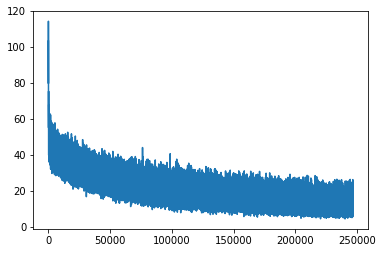

In [427]:
plt.plot(plot_losses)

In [146]:
# Save the model weights to continue later
torch.save(encoder.state_dict(), 'encoder1_lstm.pth')
torch.save(decoder.state_dict(), 'decoder1_lstm.pth')

## Part 4: Using the Model for Evaluation

In [ ]:
def get_example():
    pass

In [ ]:
def evaluate(encoder, decoder, example, idx2word, show_attention=False):
    pass

In [429]:
# Build the idx to word dictionaries to convert predicted indices to words
en_idx2word = {k:i for i, k in en_word2idx.items()}
fr_idx2word = {k:i for i, k in fr_word2idx.items()}

In [449]:
for batch in dataloader:
    input_tensor = batch['french_tensor'].to(device)
    break
    

def evaluate(input_tensor):
    pass

In [450]:
input_tensor = batch['french_tensor'][11].unsqueeze_(0)
print(batch['english_sentence'][11])
for index in input_tensor[0]:
    word = fr_idx2word[index.item()]
    if word != '<s>':
        print(word)
    else:
        print(word)
        break

his essay was concise and to the point
sa
dissertation
était
<unk>
et
<unk>
</s>
<pad>
<pad>
<pad>


In [451]:
with torch.no_grad():
    encoder_hidden = encoder.initHidden(1)
    encoder.eval()
    decoder.eval()

    encoder_output, encoder_hidden = encoder.forward(input_tensor.to(device), encoder_hidden)

    decoder_input =  torch.tensor([fr_word2idx['<s>']]*input_tensor.shape[0], dtype=torch.long, device=device).unsqueeze(0)
    decoder_hidden = (encoder_hidden[0][::2].contiguous(), encoder_hidden[1][::2].contiguous())
    #decoder_hidden = decoder.initHidden(1)

    output_list = []
    attn_weight_list = np.zeros((seq_length, seq_length))
    for di in range(seq_length):
        output, decoder_hidden, attn_weights = decoder.forward(decoder_input,
                                                               decoder_hidden,
                                                               encoder_output)

        decoder_input = output.topk(1)[1].detach()
        output_list.append(output.topk(1)[1])
        word = en_idx2word[output.topk(1)[1].item()]

        attn_weight_list[di] += attn_weights[0,0,:].cpu().numpy()


In [452]:
for index in output_list:
    word = en_idx2word[index.item()]
    if word != '</s>':
        print(word)
    else:
        print(word)
        break

his
essay
was
<unk>
and
and
</s>


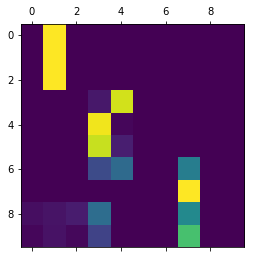

In [444]:
plt.matshow(attn_weight_list)